# Inspired by sigmoid function, we generalize it by defining:
$$ sigmoid(z) = \frac{1}{1+e^{-z/a}} \;\;\;(a > 0)$$ 

We can calculate:
$$ sigmoid'(z) = sigmoid(z) (1 - sigmoid(z)) / a$$
So:
max(sigmoid'(z)) = sigmoid'(0) = $\frac{1}{4a}$

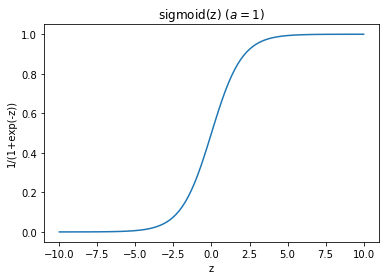

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from normalize import *
def sigmoid(z,a):
    return 1 / (1 + np.exp(-z/a))

z = np.linspace(-10,10,100)
f = sigmoid(z,1)
plt.plot(z,f)
plt.xlabel('z')
plt.ylabel('1/(1+exp(-z))')
plt.title(r'sigmoid(z) ($a = 1$)')
plt.show()

This function has a desirable property: The derivative goes to zero on each side, so it may be able to smoothly connect to a uniform plasma.

For a plasma upramp, we need a decreasing function for $\beta_m(z)$. Let's consider 1 - sigmoid(z):

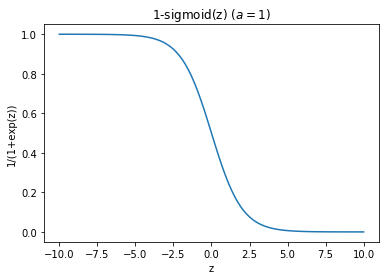

In [19]:
plt.plot(z,1-f)
plt.xlabel('z')
plt.ylabel('1/(1+exp(z))')
plt.title(r'1-sigmoid(z) ($a = 1$)')
plt.show()

But this idea needs some adjustment because we know:
$$\beta_m(z) = \sqrt{2 \gamma} \frac{c}{\omega_p(z)}$$

So $\beta_m(z)^2 * n(z)$ is a constant (assuming beam's energy $\gamma$ does not change). This means $\beta_m(z)$ should not goes to zero, otherwise the plasma density will blow up. So, instead of letting $\beta_m(z)$ decreasing from 1 to 0, we may let it decrease from $\beta_{mi}$ to $\beta_{mf}$ ($\beta_{mi}$, $\beta_{mf}$ can be calculated from the plasma density at the entrance of the upramp: $n_i$ and the end of the upramp: $n_f$ respectively). Concretely, we try:
$$\beta_m(z) = (1-sigmoid(z)) * (\beta_{mi} - \beta_{mf}) + \beta_{mf}$$
So:
$$\alpha_m(z) = -\frac{1}{2} \beta_m'(z) = \frac{1}{2a}  * sigmoid(z) (1 - sigmoid(z))(\beta_{mi} - \beta_{mf})$$
So:
$$max(|\alpha_m(z)|) = |\alpha_m(0)|  = (\beta_{mi} - \beta_{mf}) \;/\; 8a $$
The expression above must be much smaller than 1 to satisfy the adiabatic condition. So we can require $a >  \beta_{mi}$ 

So:
$$n(z) = \frac{n_f * \beta_{mf}^2}{\beta_m(z)^2}$$

Since QPAD doesn't have Twiss parameter initialization, we will assume the beam is focused to the entrance of the plasma ramp. We choose $\beta^{*} = \beta_{mi} = 5cm$. We assume in the accelerating region, $n_{p0} = 10^{17}cm^{-3}$. So in normalized unit, $\beta_{mi} = 2970$

For a 10GeV beam, $\gamma = 20000$. So $\beta_{mf} = \sqrt{2\gamma} = 200$

For these parameters, we can choose $a = 3000$

Let's plot $\beta_m(z),\alpha_m(z),n_p(z)$ under these parameters:

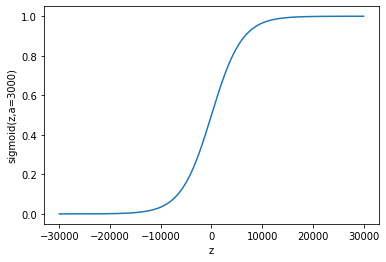

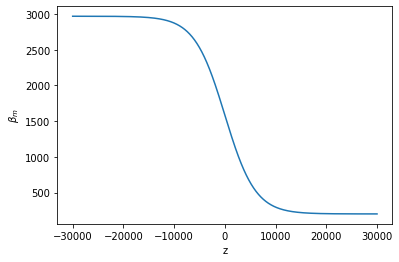

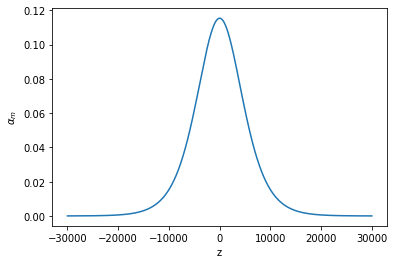

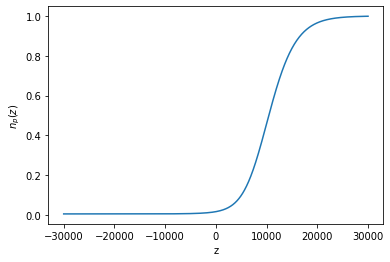

In [20]:
beta_mi = normalize(5,'cm',10)
beta_mf = 200
a = 3000
z = np.linspace(-10 * a,10 * a, 1000)
sig = sigmoid(z,a)
beta_m = (1-sig) * (beta_mi - beta_mf) + beta_mf
alpha_m = sig * (1 - sig) * (beta_mi - beta_mf) / 2 / a
n = (beta_mf / beta_m) ** 2
plt.figure(1)
plt.plot(z,sig)
plt.xlabel('z')
plt.ylabel('sigmoid(z,a='+ str(a)+')')
plt.figure(2)
plt.xlabel('z')
plt.ylabel(r'$\beta_m$')
plt.plot(z,beta_m)
plt.figure(3)
plt.xlabel('z')
plt.ylabel(r'$\alpha_m$')
plt.plot(z,alpha_m)
plt.figure(4)
plt.xlabel('z')
plt.ylabel(r'$n_p(z)$')
plt.plot(z,n)
plt.show()

In [27]:
import json
from collections import OrderedDict

density = n
s = z

def set_plasma_density(density,s):

    with open('qpinput.json') as f: # This is the old jason input file
        inputDeck = json.load(f,object_pairs_hook=OrderedDict)
    nspecies = inputDeck['simulation']['nspecies']
    for i in range(nspecies):
        inputDeck['species'][i]['piecewise_fs'] = list(density)
        inputDeck['species'][i]['piecewise_s'] = list(s)

    ## Write the modified file object into a jason file
    with open('qpinput.json','w') as outfile:
        json.dump(inputDeck,outfile,indent=4)
        
set_plasma_density(density,s)
# with open('qpinput.json') as f: # This is the old jason input file
#     inputDeck = json.load(f,object_pairs_hook=OrderedDict)